# Roles

This page shows the roles of Open Seeds people

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go

In [2]:
baseurl = "https://raw.githubusercontent.com/open-life-science/open-life-science.github.io/main/_data/artifacts/openseeds/"
cohort_nb = 8

In [3]:
people_df = pd.read_csv(f"{baseurl}people.csv", index_col=0).fillna("")

In [4]:
roles_df = {}
roles = []
for r in ["role", "participant", "mentor", "expert", "speaker", "facilitator", "organizer"]:
    role = r.capitalize()
    roles.append(role)
    roles_df[role] = pd.read_csv(f"{baseurl}/roles/{r}.csv", index_col=0)

## Roles over cohorts

In [5]:
red_roles = ["Participant", "Mentor", "Facilitator", "Speaker", "Expert"]
role_count_df = pd.DataFrame(columns = red_roles)
for r in red_roles:
    role_count_df[r] = (
        roles_df[r]
        .drop(columns = ["city", "country", "country_3", "first-name", "last-name", "pronouns", "continent", "longitude", "latitude"])
        .count(axis=0)
        .rename(index=str.upper)
    )
    role_count_df.loc["Total", r] = len(roles_df[r])
role_count_df = role_count_df.astype("int64")
role_count_df

Participant  Mentor  Facilitator  Speaker  Expert
OLS-1           29      20            0       18      37
OLS-2           52      36            0       24      65
OLS-3           66      34            1       22      63
OLS-4           34      32            7       18      46
OLS-5           71      35            5       17      26
OLS-6           41      32            7       19      39
OLS-7           54      34           10       18       4
OLS-8           69      38           15       12      22
Total          386     138           30       99     170

In [6]:
role_count_df = role_count_df.drop(index="Total")

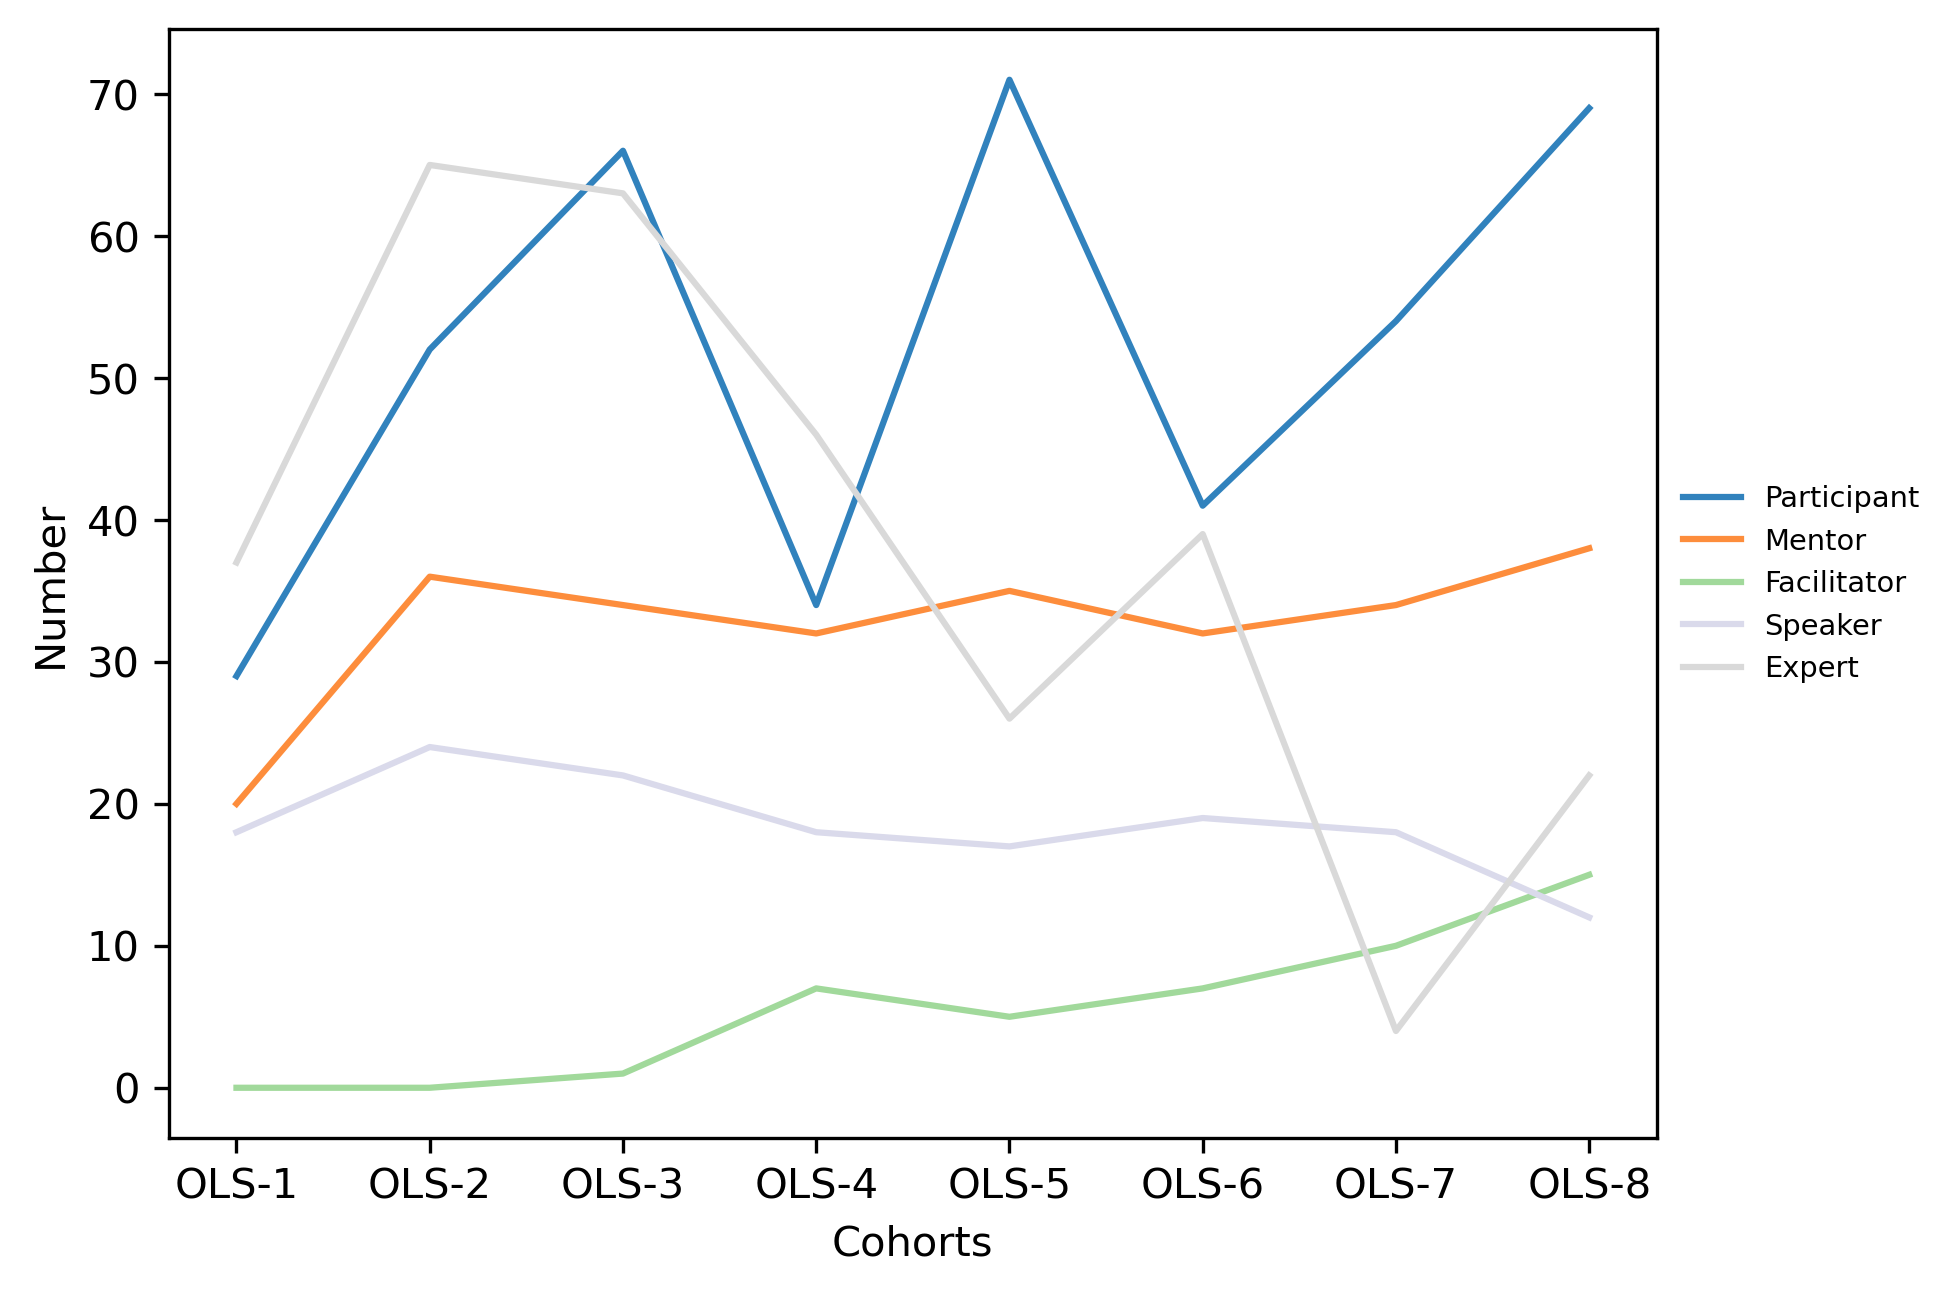

In [7]:
fig, ax = plt.subplots()
fig.set_dpi(300)
(role_count_df
     .plot(ax=ax, colormap='tab20c'))
plt.xlabel('Cohorts')
plt.ylabel('Number')
ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize='x-small')

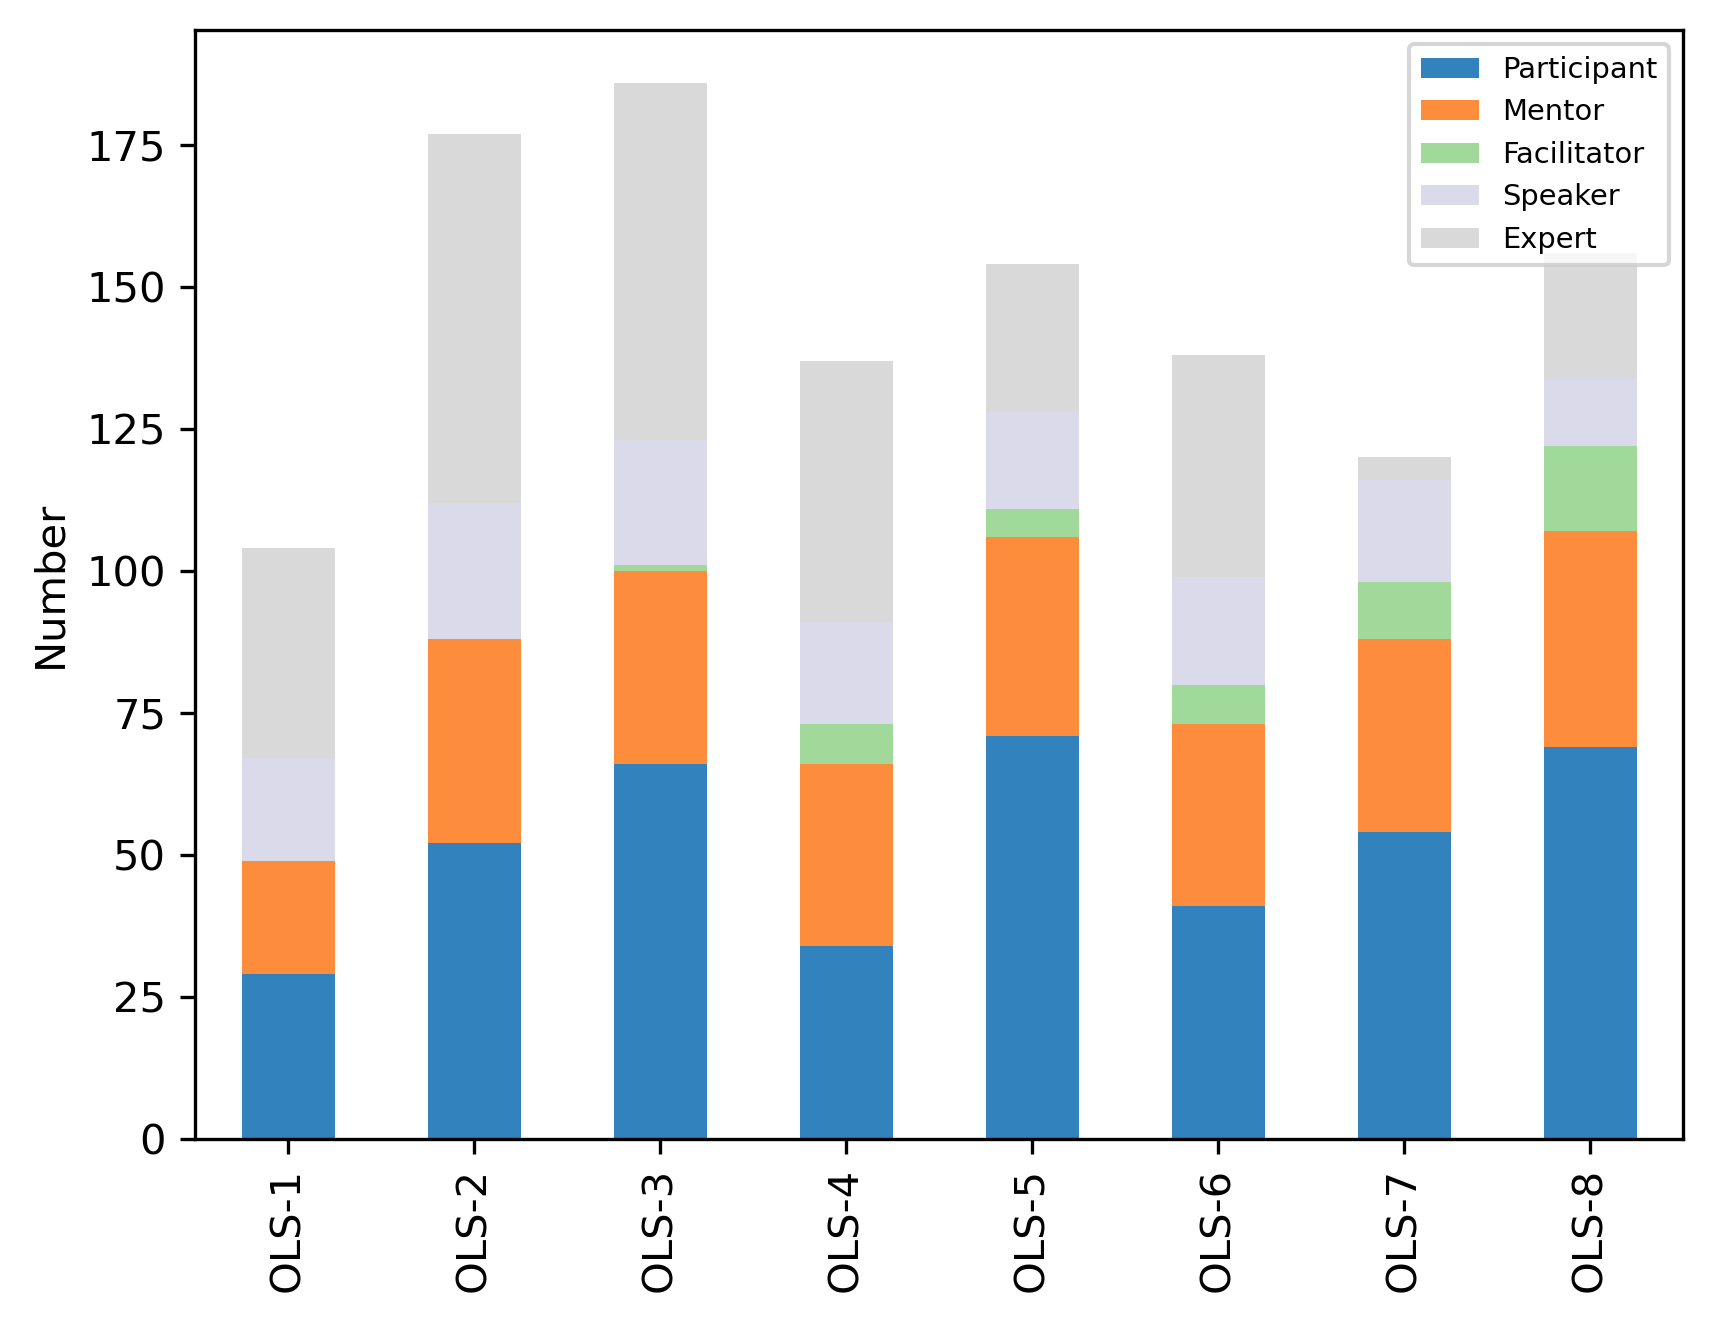

In [8]:
fig, ax = plt.subplots()
fig.set_dpi(300)
(role_count_df
     .plot.bar(ax=ax, colormap='tab20c', stacked=True))
#plt.xlabel('Cohorts')
plt.ylabel('Number')
ax.legend(
#    loc='center left',
#    bbox_to_anchor=(1, 0.5),
#    frameon=False,
    fontsize='x-small')

## Role transfer between cohorts

### Flow per cohorts

In [9]:
cohorts = list(role_count_df.index)
sources = []
targets = []
values = []

for i in range(len(cohorts)-1):
    for s in red_roles:
        source = f"{cohorts[i].lower()}-{s.lower()}"
        left_query = f"`{source}` != ''"
        # identify numbers of people that came back in next cohort
        for t in red_roles:
            target = f"{cohorts[i+1].lower()}-{t.lower()}"
            query = f"`{source}` != '' and `{target}` != ''"
            value = len(people_df.query(query))
            sources.append(source)
            targets.append(target)
            values.append(value)
            left_query += f" and `{target}` == ''"
        # identify numbers of people that did not came back in next cohort
        value = len(people_df.query(left_query))
        sources.append(source)
        targets.append(f"{cohorts[i+1].lower()}-alumni")
        values.append(value)
        
cohort_flow = pd.DataFrame({"source": sources, "target": targets, "value": values})
cohort_flow

source             target  value
0    ols-1-participant  ols-2-participant      0
1    ols-1-participant       ols-2-mentor      5
2    ols-1-participant  ols-2-facilitator      0
3    ols-1-participant      ols-2-speaker      2
4    ols-1-participant       ols-2-expert      5
..                 ...                ...    ...
205       ols-7-expert       ols-8-mentor      2
206       ols-7-expert  ols-8-facilitator      0
207       ols-7-expert      ols-8-speaker      1
208       ols-7-expert       ols-8-expert      2
209       ols-7-expert       ols-8-alumni      0

[210 rows x 3 columns]

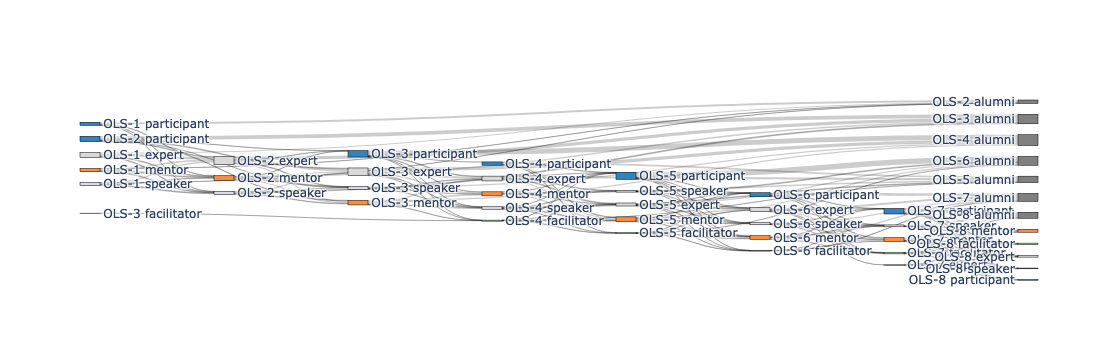

In [10]:
labels = [f"ols-{c}-{r.lower()}" for c in range(1,len(cohorts)+1) for r in red_roles + ["alumni"]]
# get index in labels for sources and targets
source_ids = [labels.index(e) for e in sources] 
target_ids = [labels.index(e) for e in targets]
# prepare label metadata for printing
colors = {
    "participant": "#3182bd",
    "mentor": "#fd8d3c",
    "expert": "#d9d9d9",
    "speaker": "#dadaeb",
    "facilitator": "#a1d99b",
    "alumni": "grey"
}
y = {
    "participant": 0.99,
    "mentor": 0.8,
    "expert": 0.6,
    "speaker": 0.4,
    "facilitator": 0.2,
    "alumni": 0.01
}
pos = (1-.2)/(len(cohorts)-1)

label_colors = [colors[l.split("-")[-1]] for l in labels]
label_x = [pos*(int(l.split("-")[1])-1)+0.01 for l in labels]
label_y = [y[l.split("-")[-1]] for l in labels]
labels = [l.replace("-", " ").replace("ols ", "OLS-") for l in labels]
label_df = pd.DataFrame({"labels": labels, "colors": label_colors, "x": label_x, "y": label_y})

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = label_df.labels,
        color = label_df.colors
    ),
    link = dict(
      source = source_ids,
      target = target_ids,
      value = values
  ))])

fig.show()

### Flow overview over all cohorts

There is a normalizaton step to be sure people coming back in several roles are counting no more that 1 time

In [11]:
cohorts = [x.lower() for x in list(role_count_df.index)]
labels = [x.lower() for x in red_roles] + ["alumni"]
role_flow_df = pd.DataFrame({
    "source": [l for subl in [[l]*len(labels) for l in labels] for l in subl], 
    "target": labels*len(labels), 
    "value": 0
})

for index, row in role_flow_df.iterrows():
    if row.source == "alumni":
        continue
    elif row.target == "alumni":
        for i in range(len(cohorts)-1):
            source = f"{cohorts[i]}-{row.source}"
            # build query with any role in the cohort and no role after in the following cohort
            query = f"`{source}` != ''"
            for r in red_roles:
                target = f"{cohorts[i+1]}-{r.lower()}"
                query += f"and `{target}` == ''"
            role_flow_df.at[index, "value"] += len(people_df.query(query))
    else:
        for i in range(len(cohorts)-1):
            source = f"{cohorts[i]}-{row.source}"
            target = f"{cohorts[i+1]}-{row.target}"
            # build query the source role for a cohort and target role for the following cohort
            query = f"`{source}` != '' and `{target}` != ''"
            query_res = people_df.query(query)
            # check for each result how many roles in cohort and following cohort to normalize the value
            value = 0
            new_role_nb = len(q_r[f"{cohorts[i+1]}-role"].split(","))
            for q_i, q_r in query_res.iterrows():
                value += 1/(new_role_nb)
            role_flow_df.at[index, "value"] += value
role_flow_df

NameError: name 'q_r' is not defined

Participants re-joining (%)

In [ ]:
role = 'participant'
role_nb = role_flow_df.query(f"source == '{ role }'").value.sum()
role_wo_alumni = role_flow_df.query(f"source == '{ role }' and target != 'alumni'").value.sum()
100 * role_wo_alumni  / role_nb

Mentors re-joining (%)

In [ ]:
role = 'mentor'
role_nb = role_flow_df.query(f"source == '{ role }'").value.sum()
role_wo_alumni = role_flow_df.query(f"source == '{ role }' and target != 'alumni'").value.sum()
100 * role_wo_alumni  / role_nb

In [ ]:
label_df = pd.DataFrame({
    "labels": [l.capitalize() for l in labels] * 2, 
    "colors": [colors[l] for l in labels] * 2, 
    "x": [0.1]*len(labels)+[0.9]*len(labels), 
    "y": [0.1]*(len(labels)*2)})

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = label_df.labels,
        color = label_df.colors,
    ),
    link = dict(
      source = [labels.index(e) for e in role_flow_df.source],
      target = [labels.index(e)+len(labels) for e in role_flow_df.target],
      value = role_flow_df.value
  ))])

fig.update_layout(
    font_size=18,
    width=950,
    height=400,
    margin=go.layout.Margin(
        l=10, #left margin
        r=10, #right margin
        b=20, #bottom margin
        t=20, #top margin
    )
)

fig.show()